# **Classification**

In this chapter, we will be using the MNIST dataset, which is a set of 70,000 small images of digits handwritten by high school students and employees of the US Census Bureau.  

Each image is labeled with the digit it represents.  

---

## **Installations**

In [1]:
! pip install matplotlib numpy pandas scipy scikit-learn seaborn

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os

%matplotlib inline

---

## **Fetch data**

In [3]:
# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "classification"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [4]:
# Sort data

def sort_by_target(mnist):
    reorder_train = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[:60000])]))[:, 1]
    reorder_test = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[60000:])]))[:, 1]
    mnist.data[:60000] = mnist.data[reorder_train]
    mnist.target[:60000] = mnist.target[reorder_train]
    mnist.data[60000:] = mnist.data[reorder_test + 60000]
    mnist.target[60000:] = mnist.target[reorder_test + 60000]

In [5]:
try:
    from sklearn.datasets import fetch_openml
    mnist = fetch_openml('mnist_784', version=1, cache=True, as_frame=False)
    mnist.target = mnist.target.astype(np.int8) # fetch_openml() returns targets as strings
    sort_by_target(mnist) # fetch_openml() returns an unsorted dataset
except ImportError:
    from sklearn.datasets import fetch_mldata
    mnist = fetch_mldata('MNIST original')
X, y = mnist["data"], mnist["target"]

In [6]:
# Each image is 28×28 pixels, and each feature simply represents one pixel’s intensity, from 0 (white) to 255 (black)

print(f"There are {X.shape[0]} images and each image has {X.shape[1]} features")

There are 70000 images and each image has 784 features


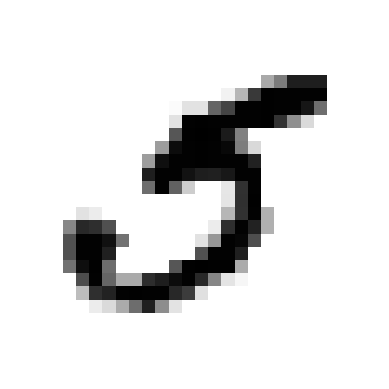

Check, y value: 5


In [7]:
# Look at one digit from the dataset.
# Grab an instance’s feature vector, reshape it to a 28×28 array.

some_digit = X[36000]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap = matplotlib.cm.binary,
           interpolation="nearest")
plt.axis("off")
plt.show()
print(f"Check, y value: {y[36000]}")

---

## **Train, test split**

The MNIST dataset is already split into a training set (the first 60,000 images) and a test set (the last 10,000 images)

In [8]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

---

## **Suffle training data**

Suffling the training set guarantees that all cross-validation folds will be similar (you don’t want one fold to be missing some digits).  
Moreover, some learning algorithms are sensitive to the order of the training instances, and they perform poorly if they get many similar instances in a row.  
Shuffling the dataset ensures that this won’t happen.

In [9]:
shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

### **Binary classifier**

Training on just being able to identify the number 5 or not 5

Stochastic Gradient Descent (SGD) classifier has the advantage of being capable of handling very large datasets efficiently.  
This is in part because SGD deals with training instances independently, one at a time (which also makes SGD well suited for online learning).  
The SGDClassifier relies on randomness during training (hence the name “stochastic”). If you want reproducible results, you should set the random_state parameter.

In [20]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [24]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=5, random_state=42)
sgd_clf.fit(X_train, y_train_5)

/opt/miniconda3/envs/hands-on-ml/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


SGDClassifier(max_iter=5, random_state=42)

In [23]:
# make predictions

some_digit = X[36000] # this is 5
sgd_clf.predict([some_digit])

array([ True])

In [18]:
y_train_5

array([False, False, False, ..., False, False, False], shape=(60000,))

---

## **Measuring performance**

In [25]:
from sklearn.model_selection import cross_val_score

# in regression we score based on neg_mean_squared_error
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

/opt/miniconda3/envs/hands-on-ml/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/opt/miniconda3/envs/hands-on-ml/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/opt/miniconda3/envs/hands-on-ml/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


array([0.9577, 0.9627, 0.9613])

If you want more control over cross-validation you may want to implement your own version of <code>cross_val_score()</code>.  

The <code>StratifiedKFold</code> class performs stratified sampling to produce folds that contain a representative ratio of each class.  
At each iteration the code creates a clone of the classifier, trains that clone on the training folds, and makes predictions on the test fold (each sample appears in exactly one validation set per cycle).  
Then it counts the number of correct predictions and outputs the ratio of correct predictions.  

In [27]:
# Implementing cross_val_score manually for greater customisation
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = (y_train_5[train_index])
    X_test_fold = X_train[test_index]
    y_test_fold = (y_train_5[test_index])

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

/opt/miniconda3/envs/hands-on-ml/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


0.9557


/opt/miniconda3/envs/hands-on-ml/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


0.9636
0.9684


/opt/miniconda3/envs/hands-on-ml/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy is high as number 5 appears in only about 10% of the images.  
This demonstrates why accuracy is generally not the preferred performance measure for classifiers, especially when you are dealing with skewed datasets (i.e., when some classes are much more frequent than others).